<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Used_Car_Quality_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 2.5 MB/s 
     |████████████████████████████████| 166.7 MB 8.2 kB/s 
     |████████████████████████████████| 2.0 MB 48.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 


In [2]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [3]:
od.download('https://www.kaggle.com/c/DontGetKicked/data?select=test.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


 49%|████▉     | 5.00M/10.2M [00:00<00:00, 39.9MB/s]

100%|██████████| 10.2M/10.2M [00:00<00:00, 50.0MB/s]



Extracting archive ./DontGetKicked/DontGetKicked.zip to ./DontGetKicked


In [4]:
os.listdir('DontGetKicked')

['example_entry.csv',
 'test.zip',
 'training.zip',
 'Carvana_Data_Dictionary.txt',
 'training.csv',
 'test.csv']

In [5]:
car_data=pd.read_csv('/content/DontGetKicked/training.csv', index_col=0) 
car_data

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
RefId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,1.0,Alloy,45234,AMERICAN,MEDIUM,FORD,1996.0,2993.0,2656.0,3732.0,2190.0,3055.0,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,NaN,NaN,71759,AMERICAN,MEDIUM,GM,6418.0,7325.0,7431.0,8411.0,6785.0,8132.0,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,1.0,Alloy,88500,AMERICAN,MEDIUM SUV,CHRYSLER,8545.0,9959.0,9729.0,11256.0,8375.0,9802.0,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893


Preprocessing and Feature Engineering

In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IsBadBuy                           72983 non-null  int64  
 1   PurchDate                          72983 non-null  object 
 2   Auction                            72983 non-null  object 
 3   VehYear                            72983 non-null  int64  
 4   VehicleAge                         72983 non-null  int64  
 5   Make                               72983 non-null  object 
 6   Model                              72983 non-null  object 
 7   Trim                               70623 non-null  object 
 8   SubModel                           72975 non-null  object 
 9   Color                              72975 non-null  object 
 10  Transmission                       72974 non-null  object 
 11  WheelTypeID                        69814 non-null  flo

In [7]:
def split_date(df):
  df['PurchDate'] = pd.to_datetime(df['PurchDate'])
  df['Year'] = df.PurchDate.dt.year
  df['Month'] = df.PurchDate.dt.month

In [8]:
split_date(car_data)

In [9]:
car_data.head(2)

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Year,Month,Day,WeekOfYear
RefId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,2009-12-07,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113,2009,12,7,50
2,0,2009-12-07,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053,2009,12,7,50


In [10]:
car_data.Transmission = car_data.Transmission.str.upper()

Let me filter out columns which are not relevant

In [11]:
car_data.columns

Index(['IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge', 'Make',
       'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'Year', 'Month', 'Day', 'WeekOfYear'],
      dtype='object')

In [12]:
relevant_coulmns = ['IsBadBuy', 'Auction', 'VehYear', 'VehicleAge', 'Make',
       'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'VNZIP1', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'Year', 'Month']

In [13]:
car_data = car_data[relevant_coulmns]
car_data.head(2)

,IsBadBuy,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,Year,Month
RefId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,33619,7100.0,0,1113,2009,12
2,0,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,33619,7600.0,0,1053,2009,12


In [14]:
input_cols = ['Auction', 'VehYear', 'VehicleAge', 'Make',
       'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'Year', 'Month']
target_col = 'IsBadBuy'

In [15]:
inputs = car_data[input_cols].copy()
targets = car_data[target_col].copy()

In [16]:
inputs.shape

(72983, 30)

In [17]:
numeric_cols = ['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost',  'IsOnlineSale', 'WarrantyCost', 'Year', 'Month']
categorical_cols = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 
                    'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART']

Impute missing numerical data

In [18]:
## Filling missing values
inputs.WheelTypeID.fillna(0.0, inplace=True)

## Dropping the records with NaN
inputs.dropna(subset = ["MMRCurrentAuctionAveragePrice"], inplace=True)

In [19]:
inputs[numeric_cols].isna().sum()

VehYear                              0
VehicleAge                           0
WheelTypeID                          0
VehOdo                               0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
Year                                 0
Month                                0
dtype: int64

In [20]:
inputs[categorical_cols].isna().sum()

Auction                     0
Make                        0
Model                       0
Trim                     2358
SubModel                    8
Color                       8
Transmission                9
WheelType                3172
Nationality                 1
Size                        1
TopThreeAmericanName        1
PRIMEUNIT               69263
AUCGUART                69263
dtype: int64

In [21]:
inputs[categorical_cols].fillna('Unknown', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [22]:
inputs.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            73005, 73006, 73007, 73008, 73009, 73010, 73011, 73012, 73013,
            73014],
           dtype='int64', name='RefId', length=72668)

In [23]:
targets = targets[targets.index.isin(inputs.index)]

In [24]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(car_data[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [25]:
len(encoded_cols)

2151

In [26]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

In [27]:
X = inputs[numeric_cols + encoded_cols]

Gradient Boosting

In [28]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)

In [29]:
%%time

model.fit(X, targets)

[14:23:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 16s, sys: 1.08 s, total: 2min 17s
Wall time: 1min 13s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [30]:
preds = model.predict(X)

In [31]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
accuracy = accuracy_score(targets, preds)

In [34]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.05%


In [35]:
model.feature_importances_

array([0.        , 0.05525453, 0.33115178, ..., 0.01857102, 0.        ,
       0.        ], dtype=float32)

In [36]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [37]:
importance_df.head(10)

,feature,importance
2,WheelTypeID,0.331152
18,Auction_MANHEIM,0.067758
1,VehicleAge,0.055255
2136,WheelType_Covers,0.023147
2158,TopThreeAmericanName_FORD,0.022245
2162,PRIMEUNIT_NO,0.019773
2165,AUCGUART_GREEN,0.018571
12,VehBCost,0.017163
17,Auction_ADESA,0.016863
771,Model_PT CRUISER,0.016131


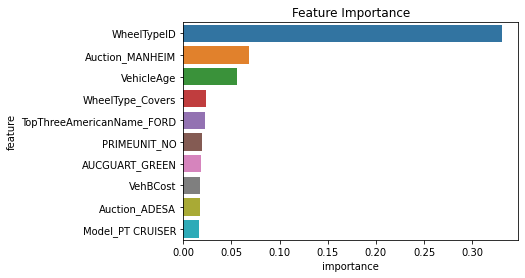

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');